In [1]:
from obs_models import *
from generate_data import *
from utils import *
%matplotlib inline

In [2]:
from scipy.stats import multivariate_normal

In [3]:
N, D = 1000, 10
random_locs = np.random.randn(D)*10
random_covariance_factor = np.random.rand(D,D)*np.random.randint(2,size=D*D).reshape(D,D)
random_covariance = np.matmul(random_covariance_factor,random_covariance_factor.T)
random_data = multivariate_normal(mean=random_locs,cov=random_covariance).rvs(size=N)

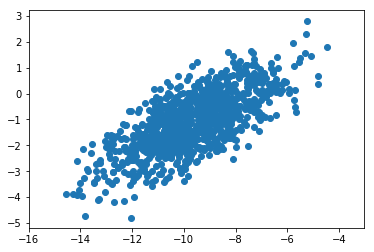

In [4]:
# plot two random dimensions against each other
pyplot.scatter(*random_data[:,np.random.choice(np.arange(D),size=2,replace=False)].T)
pyplot.axis('equal');

In [5]:
class IndependentGaussian:
    """Base class for compositional models"""
    def __init__(self, X):
        if not type(X) is torch.Tensor:
            X = torch.Tensor(X)
        self.X = X
        self.N, self.D = X.shape
        self.conditioned_model = None
        
    def __repr__(self):
        return 'G'
    
    def model(self, X):
        with pyro.plate('features', self.D):
            loc = pyro.sample('loc', dst.Normal(0.,10.))
            scale = pyro.sample('scale', dst.LogNormal(0.,4.))
            with pyro.plate('X', self.N):
                X = pyro.sample('obs', dst.Normal(loc,scale))
        return X
    
    def condition_model(self, X):
        if self.conditioned_model is None:
            self.conditioned_model = pyro.condition(self.model, data = {'obs': X})
        return self.conditioned_model(X)
    
    def guide(self, X):
        with pyro.plate('features', self.D):
            loc_delta = pyro.param('loc', torch.zeros(self.D))
            scale_delta = pyro.param('scale', torch.ones(self.D), constraint=constraints.positive)
            loc = dst.Delta(loc_delta)
            scale = dst.Delta(scale_delta)
        return loc, scale
        
    def inference(self):
        X = self.X
        self.condition_model(X)
        def per_param_callable(module_name, param_name):
            #if param_name == 'loc_mean':
            #    return {"lr": 0.0, 'betas': [0.9, 0.99]}
            #else:
            #    return {"lr": 0.01, 'betas': [0.9, 0.99]}
            return {"lr": 0.01, 'betas': [0.9, 0.99]}

        def initialize(seed):
            # evaluate loss on a randomly initialized parameter-set 
            pyro.set_rng_seed(seed)
            pyro.clear_param_store()
            # guide param names were defined by AutoDelta, with names copied from model and prefixed by 'auto_'
            # Initialize means to a single sample of X.
            pyro.param('loc', X.mean(0))
            pyro.param('scale', X.std(0), constraint=constraints.positive)
            # WHY DO I GET AN ERROR WHEN USING PYRO.CONDITION?
            #loss = svi.loss(cond_model, global_guide, X)
            loss = svi.loss(self.conditioned_model, self.guide, self.X)
            return loss

        optim = pyro.optim.Adam(per_param_callable)
        elbo = Trace_ELBO()
        svi = SVI(self.conditioned_model, self.guide, optim, loss=elbo)

        loss, seed = min((initialize(seed), seed) for seed in range(100))
        initialize(seed)
        
        # Register hooks to monitor gradient norms.
        gradient_norms = defaultdict(list)
        for name, value in pyro.get_param_store().named_parameters():
            value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

        losses = []
        for i in range(2000):
            loss = svi.step(X)
            losses.append(loss)
            print('.' if i % 100 else '\n', end='')
    
    def predictive_check(self):
        return None

In [6]:
tmp = IndependentGaussian(random_data)

In [10]:
tmp.model(random_data)

tensor([[-11.7824,  17.6399,   4.5878,  ...,   5.5214,  -1.3057,  22.1526],
        [-11.8168, -44.2481,   4.7701,  ...,   6.4508,  -1.3037,  17.4331],
        [-11.7783,  50.3713,   4.7658,  ...,   4.4810,  -1.3044,  10.7678],
        ...,
        [-11.7930, -22.4737,   4.5007,  ...,   6.6674,  -1.3074,  10.7740],
        [-11.7831, -17.7755,   4.5410,  ...,   4.7073,  -1.3029,  14.2487],
        [-11.7718,   1.6563,   4.7228,  ...,   6.7222,  -1.3043,   7.5967]])

In [14]:
trace = pyro.poutine.trace(tmp.conditioned_model).get_trace(random_data)

In [15]:
for node in trace.nodes.items():
    print(node)

('_INPUT', {'name': '_INPUT', 'type': 'args', 'args': (array([[  6.71514256,  -6.74331101,  -2.56839336, ..., -12.33631728,
         -0.21848299,  -8.82922528],
       [  9.58142188,  -2.1769689 ,   2.50024377, ..., -10.1188871 ,
          4.0041934 ,  -5.93670335],
       [  6.96879926,  -3.60803498,  -1.50347967, ..., -13.17671639,
          1.07510466,  -9.33035321],
       ...,
       [  6.44179586,  -3.14534341,  -2.06100772, ..., -11.99526432,
          2.86007727, -10.57520766],
       [  8.94252122,  -4.2566933 ,  -2.39814341, ..., -10.61415998,
          3.7515708 ,  -8.38458105],
       [  5.8724929 ,  -5.79506864,  -1.49177589, ..., -12.89384794,
         -0.74693393, -10.56497334]]),), 'kwargs': {}})
('features', {'type': 'sample', 'name': 'features', 'fn': <pyro.poutine.subsample_messenger._Subsample object at 0x7fa06836b7f0>, 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_inde

In [16]:
tmp.inference()

RuntimeError: site loc must be sample in trace
Trace Shapes:     
 Param Sites:     
Sample Sites:     
features dist    |
        value 10 |